First we give a schematic plan of the building.

In [56]:
# Import numpy library (for arrays operations)
# Import matplotlib.pyplot interface (for MATLAB-like plots)
# Use magic line '%matplotlib notebook' to allow the plot to be interactive within Jupyter Notebook

import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [57]:
# Range of coordinates indices

x, y, z = np.indices((12, 26, 6))

In [58]:
# Definition of the building (volumes and colors)

ground = (x < 12) & (y < 26) & (z < 1)
floors = (x < 12) & (y < 26) & (1 <= z) & (z < 6)
building = ground | floors

building_color = np.empty(building.shape, dtype=object)
building_color[ground] = 'grey'
building_color[floors] = 'white'

In [59]:
# Definition of the 4th floor apartments (volumes and colors)

apart_41 = (0 <= x) & (x < 12) & (19 <= y) & (y < 26) & (3 <= z) & (z < 4)
apart_42 = (8 <= x) & (x < 12) & (10 <= y) & (y < 19) & (3 <= z) & (z < 4)
apart_43 = (6 <= x) & (x < 12) & (0 <= y) & (y < 8) & (3 <= z) & (z < 4)
apart_44 = (0 <= x) & (x < 6) & (0 <= y) & (y < 10) & (3 <= z) & (z < 4)
apart_45 = (0 <= x) & (x < 6) & (10 <= y) & (y < 17) & (3 <= z) & (z < 4)
apartments = apart_41 | apart_42 | apart_43 | apart_44 | apart_45

apartments_color = np.empty(building.shape, dtype=object)
apartments_color[apart_41] = 'gold'
apartments_color[apart_42] = 'red'
apartments_color[apart_43] = 'blue'
apartments_color[apart_44] = 'violet'
apartments_color[apart_45] = 'green'

<IPython.core.display.Javascript object>


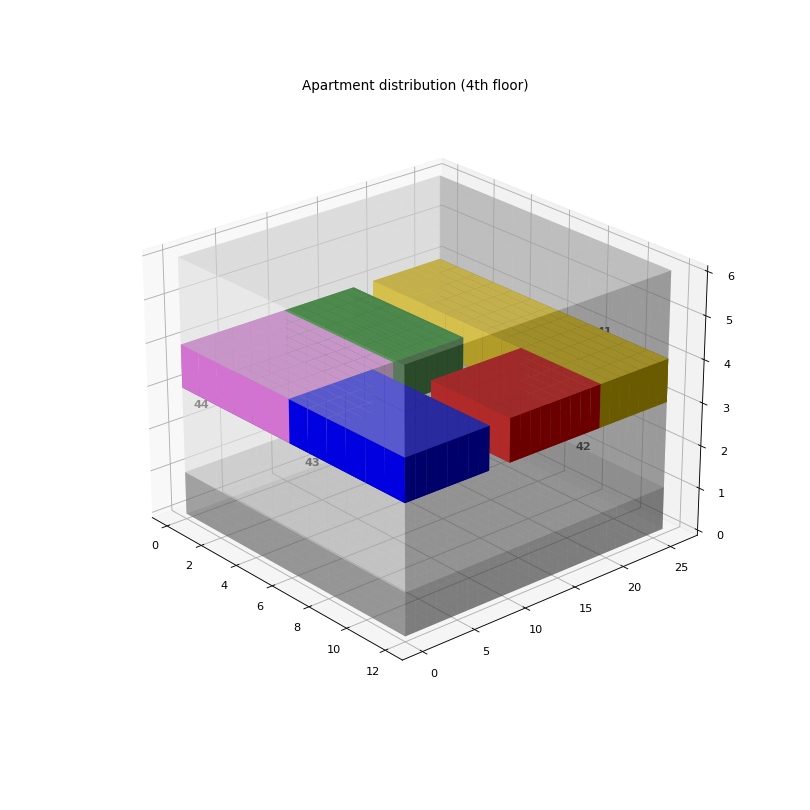

In [61]:
# Interactive 3D plot of the building

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(building, facecolors=building_color, alpha=0.4)
ax.voxels(apartments, facecolors=apartments_color)

plt.title('Apartment distribution (4th floor)')

ax.text(8.5, -3, 3.3, '43', weight='bold')
ax.text(2.5, -3, 3.3, '44', weight='bold')
ax.text(7, 29, 3.3, '41', weight='bold')
ax.text(13.5, 13.5, 3.3, '42', weight='bold')
ax.text(-1.5, 14.5, 3.3, '45', weight='bold')

plt.show()

In [49]:
# Import os module (for interacting with the operating system)
# Import pandas library (for data analysis in Python)
# Import create_engine from the sqlalchemy toolkit (standard SQL toolkit in Python)
# Import load_dotenv from the dotenv module (for setting environment variables)

import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [50]:
# Load from a (hidden) .env file the mysql credentials of the database

load_dotenv()
user = os.getenv('MYSQL_USER')
passwd = os.getenv('MYSQL_PASSWORD')
host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
db = os.getenv('MYSQL_DB')

In [51]:
engine = create_engine('mysql://%s:%s@%s:%s/%s' % (user, passwd, host, port, db))

In [81]:
df = pd.read_sql('SELECT * FROM Power LIMIT 100', engine)
df

,apartment_id,module_id,date,value
0,1026,17,2017-10-12,9242
1,1026,17,2017-10-13,10658
2,1026,17,2017-10-14,11523
3,1026,17,2017-10-15,12394
4,1026,17,2017-10-16,13260
...,...,...,...,...
95,1026,17,2018-01-15,387485
96,1026,17,2018-01-16,392215
97,1026,17,2018-01-17,396945
98,1026,17,2018-01-18,401808
